In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import TFAutoModel,AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


d:\Machine_Learning\NLP\Multimodal_Emotion_Recognition_System\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load dataset
df = pd.read_csv("merged_data.csv")
df = df[['text', 'label']]

In [4]:
df

,text,label
0,i have a feeling that i will find another idea...,sadness
1,i feel no fake sympathy can soften,sadness
2,No. I have kids_comma_ but they are toddlers.,sadness
3,i feel awkward tagging celebs in tweets or on ...,sadness
4,i feel really lonely tonight support anyone,sadness
...,...,...
125839,Did you have a lot of work done?,impressed
125840,I was watching professional rodeo last night. ...,impressed
125841,That is an amazing talent to have. I would be ...,impressed
125842,Yeah they must practice a lot. I would be afra...,impressed


In [5]:
emotions_len=len(df['label'].unique())
emotions_len


16

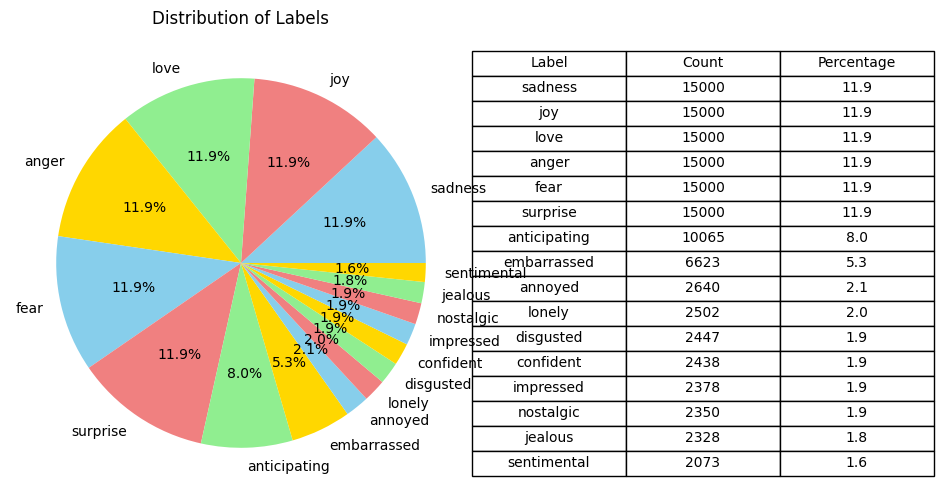

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Count values
label_counts = df['label'].value_counts()
percentages = (label_counts / label_counts.sum()) * 100  # Convert to percentage

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Pie chart
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
ax.set_title("Distribution of Labels")

# Create a table
table_data = {'Label': label_counts.index, 'Count': label_counts.values, 'Percentage': percentages.round(1)}
table_df = pd.DataFrame(table_data)

# Add table to plot
table = plt.table(cellText=table_df.values, colLabels=table_df.columns, cellLoc='center', loc='right')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Show plot
plt.show()


In [7]:
import re
import string
#Preprocess text
def preprocess_text(text):
    text=text.lower()
    text=re.sub('[^a-z A-Z 0-9]','',text)
    text= text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    text= re.sub(r'\d+', '', text)  # Remove numbers
    return text.strip()

In [8]:
df['text']=df['text'].apply(lambda x: preprocess_text(x))


In [9]:
df["text"]

0         i have a feeling that i will find another idea...
1                        i feel no fake sympathy can soften
2                 no i have kidscomma but they are toddlers
3         i feel awkward tagging celebs in tweets or on ...
4               i feel really lonely tonight support anyone
                                ...                        
125839                      did you have a lot of work done
125840    i was watching professional rodeo last night i...
125841    that is an amazing talent to have i would be s...
125842    yeah they must practice a lot i would be afrai...
125843                   me toocomma that would be terrible
Name: text, Length: 125844, dtype: object

In [10]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform labels
df["label"] = label_encoder.fit_transform(df["label"])

# Get label mappings
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Label Encoding Mapping:")
for label, index in label_mapping.items():
    print(f"{label}: {index}")


Label Encoding Mapping:
anger: 0
annoyed: 1
anticipating: 2
confident: 3
disgusted: 4
embarrassed: 5
fear: 6
impressed: 7
jealous: 8
joy: 9
lonely: 10
love: 11
nostalgic: 12
sadness: 13
sentimental: 14
surprise: 15


In [11]:
df["label"]

0         13
1         13
2         13
3         13
4         13
          ..
125839     7
125840     7
125841     7
125842     7
125843     7
Name: label, Length: 125844, dtype: int64

In [12]:
#load the RoBERTa tokenizer
tokenizer=AutoTokenizer.from_pretrained('roberta-base')

In [13]:
def tokenize_text(texts, max_length=128):
    return tokenizer(texts.tolist(), padding="max_length", truncation=True, max_length=max_length)

In [14]:
tokens = tokenize_text(df["text"])
input_ids, attention_mask = tokens["input_ids"], tokens["attention_mask"]

In [15]:
len(input_ids[0])

128

In [16]:
# Train-test split
X_train, X_test, attn_train, attn_test, y_train, y_test = train_test_split(
    input_ids, attention_mask, df["label"].values, test_size=0.2, random_state=42)

In [17]:
len(X_train[0])

128

In [18]:
# Convert labels to categorical

y_train = tf.keras.utils.to_categorical(y_train, emotions_len)
y_test = tf.keras.utils.to_categorical(y_test, emotions_len)

In [19]:
y_train.shape

(100675, 16)

In [20]:
# Load RoBERTa model
roberta_model = TFAutoModel.from_pretrained("roberta-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from transformers import TFRobertaModel, RobertaTokenizer
import torch

class RoBERTaEmbedding(tf.keras.layers.Layer):
    def __init__(self, model):
        super(RoBERTaEmbedding, self).__init__()
        self.model = model

    def call(self, inputs):
        input_ids, attention_mask = inputs["input_ids"], inputs["attention_mask"]
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return output.last_hidden_state  # Extract output
    # Explicitly define the output shape
    def compute_output_shape(self, input_shape):
        return (input_shape["input_ids"][0], input_shape["input_ids"][1], 768)  # (batch_size, seq_length, 768)



In [ ]:
from tensorflow.keras.layers import Dense,Input,LSTM,Bidirectional

def build_model(emotions_len, max_length=128): 
    input_layer=Input(shape=(max_length,),dtype=tf.int32,name="input_ids")
    attention_mask_layer=Input(shape=(max_length,),dtype=tf.float32,name="attention_mask")
    roberta_layer = RoBERTaEmbedding(roberta_model)
    roberta_output = roberta_layer({"input_ids": input_layer, "attention_mask": attention_mask_layer})
    print("Shape after RoBERTa:", roberta_output.shape)  # Debugging
    
    lstm_output=Bidirectional(LSTM(128,return_sequences=False))(roberta_output)
    print("Shape after LSTM:", lstm_output.shape)  # Debugging
    dense_output = Dense(64, activation='relu')(lstm_output)
    print("Shape after Dense(64):", dense_output.shape)  # Debugging
    final_output = Dense(emotions_len, activation='softmax')(dense_output)
    print("Final output shape:", final_output.shape)  # Debugging
    
    
    model = tf.keras.Model(inputs=[input_layer,attention_mask_layer], outputs=final_output)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])
    return model

In [23]:
model=build_model(emotions_len, 128)


Shape after RoBERTa: (None, 128, 768)
Shape after LSTM: (None, 256)
Shape after Dense(64): (None, 64)
Final output shape: (None, 16)


In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ro_ber_ta_embedding │ (None, 128, 768)  │          0 │ attention_mask[0… │
│ (RoBERTaEmbedding)  │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    918,528 │ ro_ber_ta_embedd… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      1,040 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 936,016 (3.57 MB)

 Trainable params: 936,016 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
import numpy as np
X_train = np.array(X_train)
attn_train = np.array(attn_train)

train_features = {
    'input_ids':X_train,
    'attention_mask': attn_train
}





In [ ]:
model.fit(
    train_features,y_train,
    epochs=3, batch_size=4, verbose=1
)


Epoch 1/3
25169/25169 ━━━━━━━━━━━━━━━━━━━━ 6357s 253ms/step - accuracy: 0.3516 - loss: 1.9428
Epoch 2/3
25169/25169 ━━━━━━━━━━━━━━━━━━━━ 5617s 223ms/step - accuracy: 0.4935 - loss: 1.5152
Epoch 3/3
25169/25169 ━━━━━━━━━━━━━━━━━━━━ 6170s 245ms/step - accuracy: 0.5458 - loss: 1.3690


In [29]:
import numpy as np
X_test= np.array(X_test)
attn_test = np.array(attn_test)

test_features = {
    'input_ids':X_test,
    'attention_mask': attn_test
}

y_test



array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
model.evaluate(test_features,y_test)

188/787 ━━━━━━━━━━━━━━━━━━━━ 56:45 6s/step - accuracy: 0.5628 - loss: 1.3282

KeyboardInterrupt: 